In [126]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import msprime
import numpy as np
import pandas as pd
from itertools import combinations
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_pi(haplotypes):
    ## If no seg sites in a pop then haplotypes will be 0 length
    if haplotypes.size == 0:
        return 0
    n = len(haplotypes[0])
    n_comparisons = float(n) * (n - 1) / 2

    pi = 0
    for hap in haplotypes:
        k = np.count_nonzero(hap)
        pi += float(k) * (n - k) / n_comparisons
    return(pi)


In [46]:
# Run `reps` number of simulations accumulating pi and pi* values then average over reps
def simulate(ss=10, Ne=1e4, length=5e2, reps=100, verbose=False):
    if verbose: print("s:{} Ne:{} len:{}".format(ss, int(Ne), int(length)))
    ts_pis = []
    my_pis = []
    uniq_pis = []
    nuniq = 0
    for i in range(reps):
        tree_sequence = msprime.simulate(sample_size=ss, Ne=Ne, length=length, mutation_rate=1e-8)
        ts_pis.append(tree_sequence.get_pairwise_diversity()/length)

        haps = list(tree_sequence.haplotypes())
        # Comment out _my_ pi implentation since I've demonstrated that it is exact
        # wrt msprime get_pairwise_diversity(), but msprime is faster. Saves time.
        #haps_t = np.transpose(np.array([list(map(int, list(x))) for x in haps]))
        #my_pis.append(get_pi(haps_t)/length)

        haps = set(haps)
        haps_t = np.transpose(np.array([list(map(int, list(x))) for x in haps]))
        uniq_pis.append(get_pi(haps_t)/length)
        nuniq += len(haps)

    if verbose:
        print("  TS:\t\t\t{:.5f}/{:.5f}".format(np.mean(ts_pis), np.std(ts_pis)))
        #print("  My: {:.5f}/{:.5f}".format(np.mean(my_pis), np.std(my_pis)))
        print("  Uniq (avg# {}):\t{:.5f}/{:.5f}".format(nuniq/float(reps),
                                            np.mean(uniq_pis),
                                            np.std(uniq_pis)))

    return ts_pis, uniq_pis

# Ne 10000, 500bp loci
for ss in [5, 10, 25, 50]:
    _, _ = simulate(ss=ss, reps=100, verbose=True)

s:5 Ne:10000 len:500
  TS:			0.00050/0.00068
  Uniq (avg# 1.46):	0.00093/0.00116
s:10 Ne:10000 len:500
  TS:			0.00037/0.00051
  Uniq (avg# 1.54):	0.00100/0.00113
s:25 Ne:10000 len:500
  TS:			0.00044/0.00065
  Uniq (avg# 1.75):	0.00133/0.00135
s:50 Ne:10000 len:500
  TS:			0.00035/0.00052
  Uniq (avg# 1.76):	0.00127/0.00129


In [50]:
for Ne in [10000, 100000]:
    for length in [5e2, 5e3]:
        for ss in [5, 25, 50]:
            _, _ = simulate(ss=ss, length=length, Ne=Ne, reps=500, verbose=True)

s:5 Ne:10000 len:500
  TS:			0.00040/0.00070
  Uniq (avg# 1.372):	0.00080/0.00128
s:25 Ne:10000 len:500
  TS:			0.00040/0.00057
  Uniq (avg# 1.702):	0.00122/0.00133
s:50 Ne:10000 len:500
  TS:			0.00037/0.00055
  Uniq (avg# 1.802):	0.00136/0.00138
s:5 Ne:10000 len:5000
  TS:			0.00039/0.00031
  Uniq (avg# 2.858):	0.00054/0.00040
s:25 Ne:10000 len:5000
  TS:			0.00041/0.00025
  Uniq (avg# 5.832):	0.00063/0.00028
s:50 Ne:10000 len:5000
  TS:			0.00040/0.00025
  Uniq (avg# 7.072):	0.00065/0.00029
s:5 Ne:100000 len:500
  TS:			0.00372/0.00274
  Uniq (avg# 2.914):	0.00515/0.00359
s:25 Ne:100000 len:500
  TS:			0.00402/0.00246
  Uniq (avg# 5.756):	0.00633/0.00272
s:50 Ne:100000 len:500
  TS:			0.00390/0.00267
  Uniq (avg# 7.02):	0.00633/0.00287
s:5 Ne:100000 len:5000
  TS:			0.00397/0.00255
  Uniq (avg# 4.576):	0.00417/0.00264
s:25 Ne:100000 len:5000
  TS:			0.00392/0.00202
  Uniq (avg# 16.402):	0.00417/0.00207
s:50 Ne:100000 len:5000
  TS:			0.00388/0.00191
  Uniq (avg# 25.218):	0.00416/0.0

In [173]:
def Ne_replicates(min_ne=1000, max_ne=1000000, step=30, ss=5, length=500, log=True, reps=100):
    df = pd.DataFrame(columns=["pi", "pi*"])
    if log:
        fun=np.logspace
        min_ne = np.log10(min_ne)
        max_ne = np.log10(max_ne)
    else:
        fun=np.linspace
    for Ne in fun(min_ne, max_ne, step):
        print("{} ".format(Ne), end="")
        if log: np.power(Ne, 10)
        ts_pis, uniq_pis = simulate(Ne=Ne, reps=reps, ss=ss, length=length)
        df.loc[Ne] = [ts_pis, uniq_pis]
    return df
df5_5e2 = Ne_replicates(ss=5, length=5e2)
df50_5e2 = Ne_replicates(ss=50, length=5e2)

1000.0 1268.9610031679222 1610.2620275609393 2043.3597178569416 2592.943797404667 3290.3445623126677 4175.3189365604 5298.316906283708 6723.357536499335 8531.678524172805 10826.36733874054 13738.237958832638 17433.288221999872 22122.1629107045 28072.162039411756 35622.47890262444 45203.53656360241 57361.52510448681 72789.53843983146 92367.08571873866 117210.22975334793 148735.21072935118 188739.18221350995 239502.6619987486 303919.53823131946 385662.04211634723 489390.0918477499 621016.9418915616 788046.2815669904 1000000.0 1000.0 1268.9610031679222 1610.2620275609393 2043.3597178569416 2592.943797404667 3290.3445623126677 4175.3189365604 5298.316906283708 6723.357536499335 8531.678524172805 10826.36733874054 13738.237958832638 17433.288221999872 22122.1629107045 28072.162039411756 35622.47890262444 45203.53656360241 57361.52510448681 72789.53843983146 92367.08571873866 117210.22975334793 148735.21072935118 188739.18221350995 239502.6619987486 303919.53823131946 385662.04211634723 4893

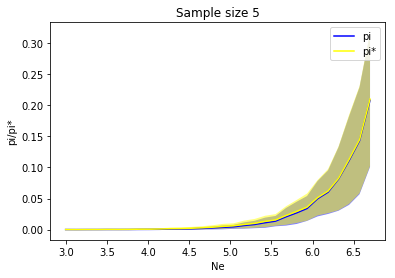

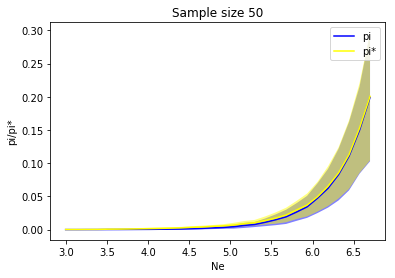

In [159]:
def plot_Ne_replicates(df, title=""):
    fig, ax = plt.subplots(1)
    Nes = np.log10(df.index.values)
#    Nes = df.index.values
    for p, c in zip(["pi", "pi*"], ['blue', 'yellow']):
        pi_means = df[p].apply(np.mean)
        pi_std = df[p].apply(np.std)
        ax.plot(Nes, pi_means, label=p, c=c)
        ax.fill_between(Nes, pi_means+pi_std, pi_means-pi_std, facecolor=c, alpha=0.5)
        ax.set_xlabel("Ne")
        ax.set_ylabel("pi/pi*")
        ax.set_title(title)
        ax.legend()
# length 500
plot_Ne_replicates(df5_5e2, title="Sample size 5")
plot_Ne_replicates(df50_5e2, title="Sample size 50")

1000 10900 20800 30700 40600 50500 60400 70300 80200 90100 1000 10900 20800 30700 40600 50500 60400 70300 80200 90100 

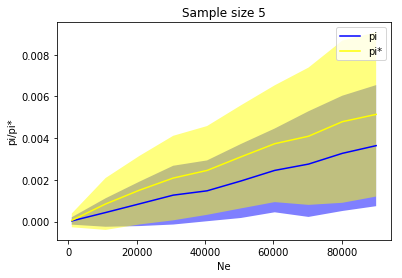

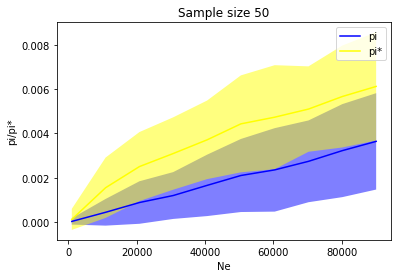

In [107]:
# length 500
df5_5e2 = Ne_replicates(ss=5, length=5e2)
df50_5e2 = Ne_replicates(ss=50, length=5e2)
plot_Ne_replicates(df5_5e2, title="Sample size 5")
plot_Ne_replicates(df50_5e2, title="Sample size 50")

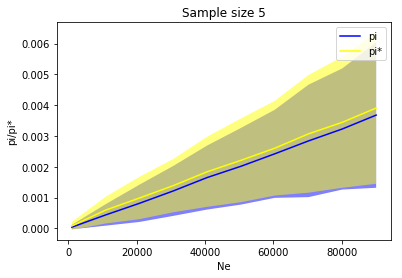

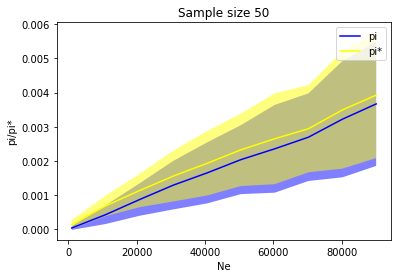

In [105]:
# length 5000
df5_5e3 = Ne_replicates(ss=5, length=5e3)
df50_5e3 = Ne_replicates(ss=50, length=5e3)
plot_Ne_replicates(df5_5e3, title="Sample size 5")
plot_Ne_replicates(df50_5e3, title="Sample size 50")

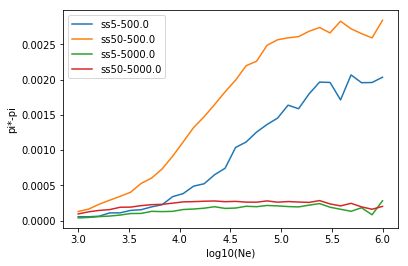

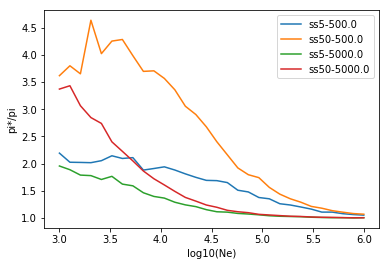

In [181]:
def plot_diffs(df1, df2, ax=None, diff="sub", length=500):
    if not ax:
        fig, ax = plt.subplots(1)
    Nes = np.log10(df5_5e2.index.values)
    if diff == "sub":
        small = df1["pi*"].apply(np.mean) - df1["pi"].apply(np.mean)
        large = df2["pi*"].apply(np.mean) - df2["pi"].apply(np.mean)
        ax.set_ylabel("pi*-pi")
    else:
        small = df1["pi*"].apply(np.mean)/df1["pi"].apply(np.mean)
        large = df2["pi*"].apply(np.mean)/df2["pi"].apply(np.mean)
        ax.set_ylabel("pi*/pi")
    ax.plot(Nes, small, label="ss5-{}".format(length))
    ax.plot(Nes, large, label="ss50-{}".format(length))
    ax.set_xlabel("log10(Ne)")
    ax.legend()
    return ax
ax5e2 = plot_diffs(df5_5e2, df50_5e2, length=5e2)
ax5e3 = plot_diffs(df5_5e2, df50_5e2, length=5e2, diff='div')
_ = plot_diffs(df5_5e3, df50_5e3, ax=ax5e2, length=5e3)
_ = plot_diffs(df5_5e3, df50_5e3, ax=ax5e3, length=5e3, diff='div')

In [174]:
reps=500
df5_5e2 = Ne_replicates(ss=5, length=5e2, reps=reps)
df50_5e2 = Ne_replicates(ss=50, length=5e2, reps=reps)
df5_5e3 = Ne_replicates(ss=5, length=5e3, reps=reps)
df50_5e3 = Ne_replicates(ss=50, length=5e3, reps=reps)

1000.0 1268.9610031679222 1610.2620275609393 2043.3597178569416 2592.943797404667 3290.3445623126677 4175.3189365604 5298.316906283708 6723.357536499335 8531.678524172805 10826.36733874054 13738.237958832638 17433.288221999872 22122.1629107045 28072.162039411756 35622.47890262444 45203.53656360241 57361.52510448681 72789.53843983146 92367.08571873866 117210.22975334793 148735.21072935118 188739.18221350995 239502.6619987486 303919.53823131946 385662.04211634723 489390.0918477499 621016.9418915616 788046.2815669904 1000000.0 1000.0 1268.9610031679222 1610.2620275609393 2043.3597178569416 2592.943797404667 3290.3445623126677 4175.3189365604 5298.316906283708 6723.357536499335 8531.678524172805 10826.36733874054 13738.237958832638 17433.288221999872 22122.1629107045 28072.162039411756 35622.47890262444 45203.53656360241 57361.52510448681 72789.53843983146 92367.08571873866 117210.22975334793 148735.21072935118 188739.18221350995 239502.6619987486 303919.53823131946 385662.04211634723 4893

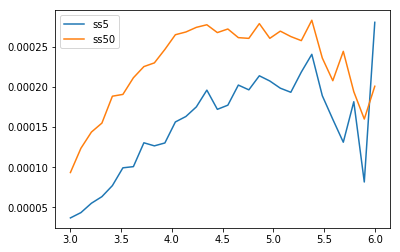

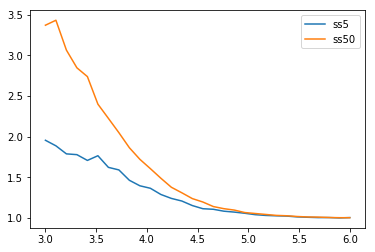

In [175]:
plot_diffs(df5_5e3, df50_5e3)
plot_diffs(df5_5e3, df50_5e3, diff='div')

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


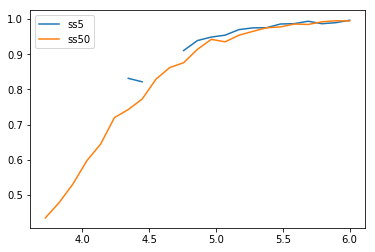

In [172]:
def plot_diffs_corrected(df1, df2, diff="sub"):
    fig, ax = plt.subplots(1)
    Nes = np.log10(df5_5e2.index.values)
    if diff == "sub":
        small = [np.mean(np.array(df1["pi*"][x]) - np.array(df1["pi"][x])) for x in df1.index]
        large = [np.mean(np.array(df2["pi*"][x]) - np.array(df2["pi"][x])) for x in df2.index]
    else:
        small = [np.mean(np.array(df1["pi"][x])/np.array(df1["pi*"][x])) for x in df1.index]
        large = [np.mean(np.array(df2["pi"][x])/np.array(df2["pi*"][x])) for x in df2.index]
    ax.plot(Nes, small, label="ss5")
    ax.plot(Nes, large, label="ss50")
    ax.legend()
plot_diffs_corrected(df5_5e3, df50_5e3, diff='div')


## Trash below here
Experiment with multiple downsampling, but this is kind of dumb. Averaging
all possible combinations is identical to actually just using all the samples
in the first place.

In [153]:
def resample(haps, length=5e3, nresamples=5, verbose=False):
    totpi = 0
    minsamps = 5
    if len(haps) < minsamps:
        minsamps = len(haps) - 1
    if minsamps <=1:
        haps_t = np.transpose(np.array([list(map(int, list(x))) for x in haps]))
        return get_pi(haps_t)/length 
    for comb in list(combinations(haps, minsamps))[:nresamples]:
        haps_t = np.transpose(np.array([list(map(int, list(x))) for x in comb]))
        totpi += get_pi(haps_t)/length
    ncombs = len(list(combinations(haps, minsamps)))
    if verbose: print("ncombs: {}".format(ncombs))
    nresamples = min([nresamples, ncombs])
    return totpi/float(nresamples)
haps = simulate(ss=50, reps=1)
resample(haps, verbose=True)

  TS: 0.00428897959184
  My: 0.00428897959184
  Uniq (avg# 11.0): 0.0056
  Resampled to <=5: 0.00488
ncombs: 462


0.0004879999999999999